<Axes: >

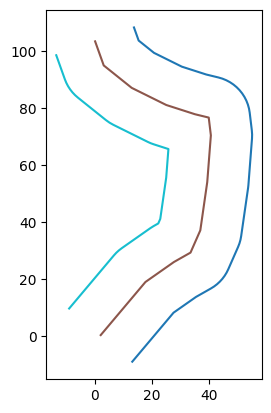

In [83]:
import pickle, os
import sys
sys.path.insert(0, "/home/adriano/projeto_mestrado/modules/")

import geopandas as gpd
import background_generation as backgen

root_dir ="/home/adriano/projeto_mestrado/modules"

img_dir = root_dir + '/Imagens/vessel_data/images'
#Varrendo o diretório
# filenames = []
# for filename in os.listdir(img_dir):    
#   filenames.append(filename.split('.')[0])
# filenames = filenames[:20]

imag = 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 2-20X'

#Lendo o pickle e gerando o vessel_map
idx = 1
pickle_dir = f'{root_dir}/Vessel_Models_pickle'
path = (pickle_dir + f'/{imag}_savedata1.pickle')
arquivo = pickle.load(open(path, 'rb'))
vessel_map = arquivo['vessel_model'].vessel_map
mapa_original = vessel_map.mapped_values

#Lendo o Json
#arquivo = f'{root_dir}/Artificial_Lines/arquivo_quatro_pontos.json'
#arquivo = f'{root_dir}/Artificial_Lines/arquivo_quatro_pontos.json'
#arquivo = f'{root_dir}/Artificial_Lines/teste_31_05.json'
arquivo = f'{root_dir}/Artificial_Lines/teste2_31_05.json'
#arquivo = f'{root_dir}/Artificial_Lines/teste.json'

medial_path = backgen.retorna_paths(arquivo)
caminhos_transladados_interpolado = backgen.retorna_caminhos_transladados(medial_path[0], 2)

linha_central,linha_offset_esquerda,linha_offset_direita, maior_tamanho = backgen.retorna_linhas_offset_posicao_tamanho(mapa_original,caminhos_transladados_interpolado[0])

gp4 = gpd.GeoSeries([linha_offset_esquerda, linha_central, linha_offset_direita])
gp4.plot(cmap="tab10")


**Plotando os pontos**

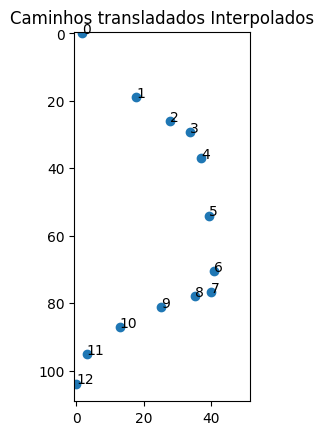

In [84]:
pontos_x = caminhos_transladados_interpolado[0][:,0]
pontos_y = caminhos_transladados_interpolado[0][:,1]
backgen.plotar_pontos(pontos_x, pontos_y, 'Caminhos transladados Interpolados' )

 ***Exibição do mapa normal***


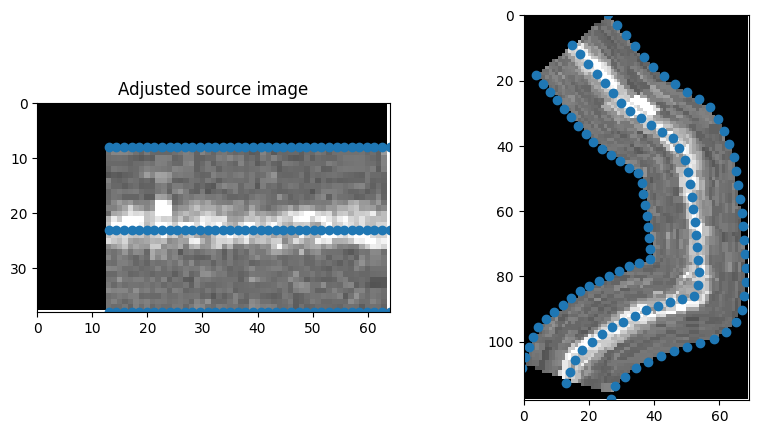

In [85]:
import numpy as np

mapa = np.array(mapa_original)

rows, cols = mapa.shape[0], mapa.shape[1]

src_cols = np.linspace(0, cols, maior_tamanho)
src_rows = np.linspace(-1, rows, 3)
src_cols, src_rows = np.meshgrid(src_cols,src_rows)
src = np.dstack([src_cols.flat, src_rows.flat])[0]

dst_array_np = backgen.retorna_dst_array_np(linha_central,linha_offset_esquerda,linha_offset_direita, maior_tamanho)

img_proper, img_out, new_src, new_dst, tform = backgen.transform_v2(src, dst_array_np, mapa)
backgen.plot(img_proper, img_out, new_src, new_dst, 60)

**Lendo o pickle e gerando o vessel_map e a imagem binária sem artefatos**

[]

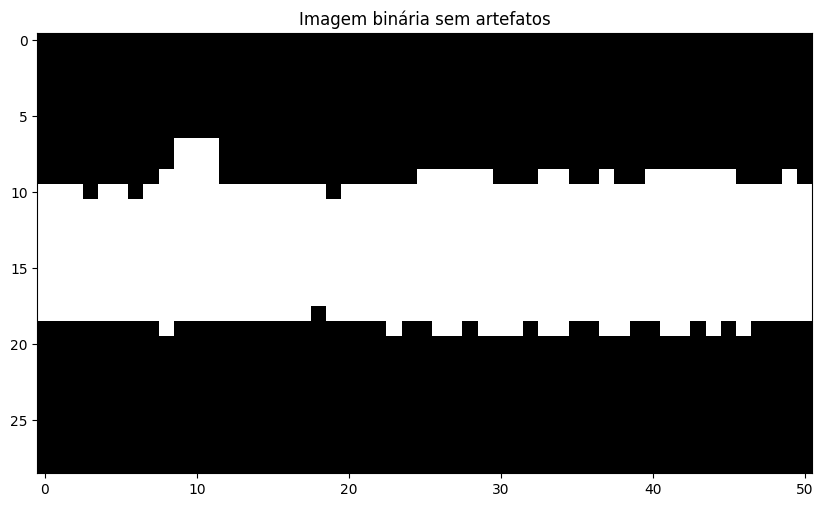

In [86]:
#import cv2
from PIL import Image
import matplotlib.pyplot as plt

img = np.array(Image.open(img_dir + f'/{imag}.tiff'))

path = (pickle_dir + f'/{imag}_savedata1.pickle')

arquivo = pickle.load(open(path, 'rb'))

vessel_map = arquivo['vessel_model'].vessel_map

mapa_original = vessel_map.mapped_values

#cv2.imwrite('mapa_original.png', mapa_original)

imagem_binaria_original = vessel_map.mapped_mask_values

imagem_binaria_sem_artefatos_laterais = backgen.retornar_imagem_binaria_sem_artefatos(vessel_map, imagem_binaria_original)


imagem_binaria_sem_artefatos = backgen.fill_holes(imagem_binaria_sem_artefatos_laterais)


plt.figure(figsize=[10, 8])
plt.title("Imagem binária sem artefatos")
plt.imshow(imagem_binaria_sem_artefatos, 'gray', vmin=0, vmax=1)
plt.plot()

Expandir mapas

In [87]:
maior_valor_interpolado = np.max(caminhos_transladados_interpolado[0])
mapa_expandido_original = backgen.expandir_mapas_do_tamanho_do_tracado(mapa_original,maior_valor_interpolado)
mapa_expandido_bin = backgen.expandir_mapas_do_tamanho_do_tracado(imagem_binaria_sem_artefatos,maior_valor_interpolado)
mask_mapa_expandido_bin = np.ones(mapa_expandido_bin.shape)

### Exibindo o Mapa Aumentado

[]

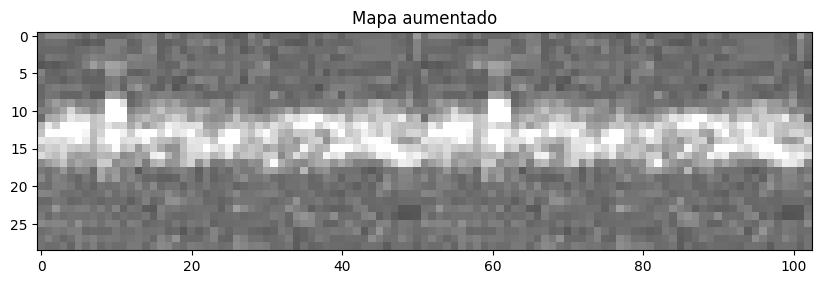

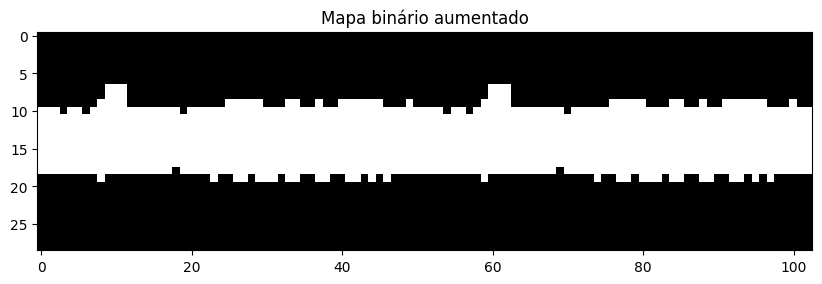

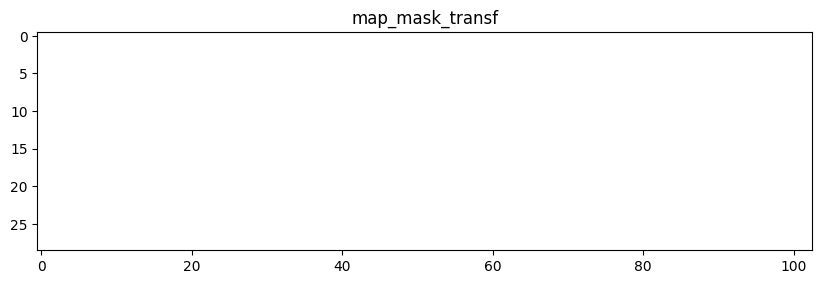

In [88]:
plt.figure(figsize=[10, 8])
plt.title("Mapa aumentado")
plt.imshow(mapa_expandido_original, 'gray', vmin=0, vmax=60)
plt.plot()
plt.figure(figsize=[10, 8])
plt.title("Mapa binário aumentado")
plt.imshow(mapa_expandido_bin, 'gray', vmin=0, vmax=1)
plt.plot()
plt.figure(figsize=[10, 8])
plt.title("map_mask_transf")
plt.imshow(mask_mapa_expandido_bin, 'gray', vmin=0, vmax=1)
plt.plot()

Execução do Algoritmo com o Mapa Expandido

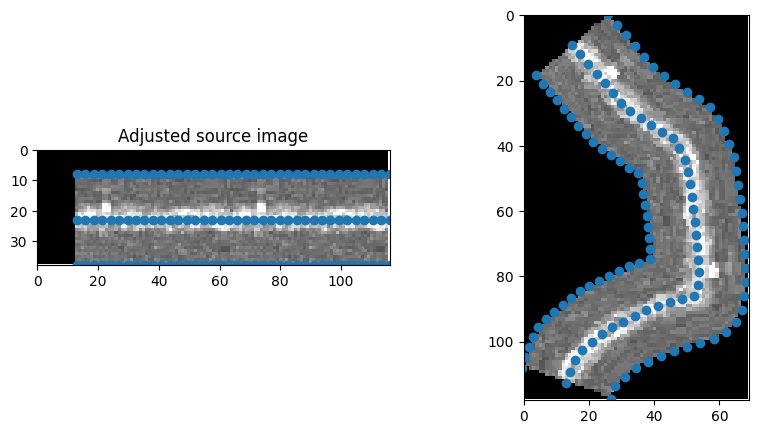

In [89]:
rows, cols = mapa_expandido_original.shape[0], mapa_expandido_original.shape[1]

src_cols = np.linspace(0, cols, maior_tamanho)
src_rows = np.linspace(-1, rows, 3)
src_cols, src_rows = np.meshgrid(src_cols,src_rows)
src = np.dstack([src_cols.flat, src_rows.flat])[0]


img_proper, img_out, new_src, new_dst, tform_out = backgen.transform_v2(src, dst_array_np, mapa_expandido_original)
backgen.plot(img_proper, img_out, new_src, new_dst,vmax=60)

In [115]:

# print(new_dst)
# for i in range(len(new_dst)):
#     print(new_dst[i])

tam = len(new_dst)

div = tam//3

vetor_div =[div,div*2,div*3]

parte_direita = new_dst[0:vetor_div[0]]
parte_centro = new_dst[vetor_div[0]:vetor_div[1]]
parte_esquerda = new_dst[vetor_div[1]:vetor_div[2]]

#a exibição é em coluna linha
print(parte_direita)
print(parte_centro)
print(parte_esquerda)

parte_esquerda[0] 


[[ 25.94484292  -0.34093829]
 [ 28.697211     2.9269187 ]
 [ 31.44957908   6.19477569]
 [ 34.20194716   9.46263268]
 [ 36.95431524  12.73048967]
 [ 39.70668332  15.99834667]
 [ 42.93979579  18.74096899]
 [ 46.43787073  21.19410802]
 [ 50.02104007  23.51263459]
 [ 53.73758517  25.62017152]
 [ 57.10033931  28.23078715]
 [ 59.5606613   31.70270926]
 [ 61.31477196  35.59778702]
 [ 63.03520285  39.50861007]
 [ 64.35252673  43.55874727]
 [ 64.9814889   47.78427905]
 [ 65.58918077  52.01336051]
 [ 66.19687264  56.24244197]
 [ 66.80456451  60.47152342]
 [ 67.19962045  64.72459951]
 [ 67.52944371  68.98436899]
 [ 67.85926697  73.24413846]
 [ 68.18909023  77.50390794]
 [ 68.12629268  81.76573622]
 [ 67.61746415  86.00784806]
 [ 66.83288098  90.19925671]
 [ 64.93161329  94.00793562]
 [ 62.00745082  97.09967028]
 [ 58.31255579  99.20886423]
 [ 54.20235305 100.35771538]
 [ 50.09392441 101.52017127]
 [ 46.02655496 102.82819463]
 [ 42.05578519 104.37413369]
 [ 38.22782898 106.27180875]
 [ 34.39987277

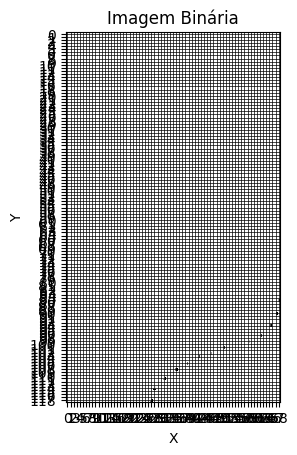

[]

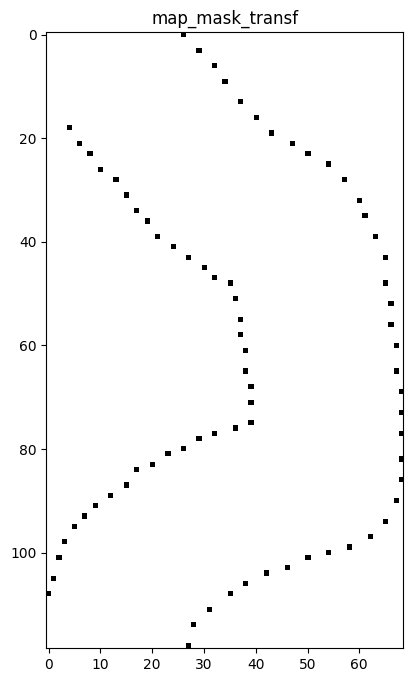

In [123]:
vetor1 = parte_direita
vetor2 = parte_esquerda

# Definir limites para a grade
x_min = min(np.min(vetor1[:, 0]), np.min(vetor2[:, 0]))
x_max = max(np.max(vetor1[:, 0]), np.max(vetor2[:, 0]))
y_min = min(np.min(vetor1[:, 1]), np.min(vetor2[:, 1]))
y_max = max(np.max(vetor1[:, 1]), np.max(vetor2[:, 1]))

# Criar uma grade vazia
grid = np.zeros((int(y_max - y_min) + 1, int(x_max - x_min) + 1))

# Preencher a grade com as coordenadas do vetor1
for x, y in vetor1:
    grid[int(y - y_min), int(x - x_min)] = 1

# Preencher a grade com as coordenadas do vetor2
for x, y in vetor2:
    grid[int(y - y_min), int(x - x_min)] = 1

# Preencher o intervalo entre os pontos com 1
for i in range(len(vetor1)):
    x1, y1 = vetor1[i]
    x2, y2 = vetor2[i]
    plt.fill_between([x1, x2], [y1 - y_min, y2 - y_min], color='white')

# Plotar a imagem binária
plt.imshow(grid, cmap='binary')
plt.xticks(np.arange(grid.shape[1]))
plt.yticks(np.arange(grid.shape[0]))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Imagem Binária')
plt.grid(True, color='black', linewidth=0.5)
plt.show()

plt.figure(figsize=[10, 8])
plt.title("map_mask_transf")
plt.imshow(grid, cmap='binary')
plt.plot()

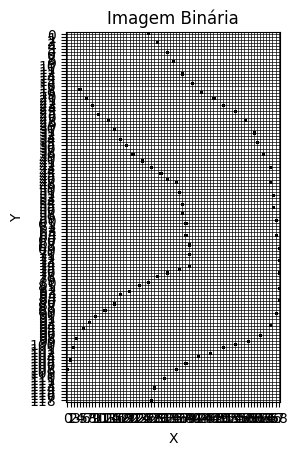

[]

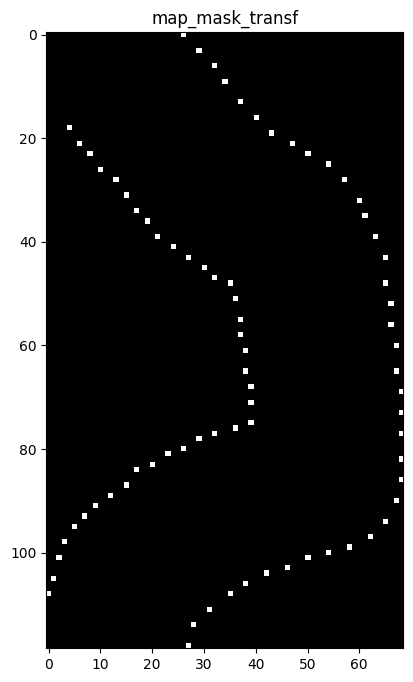

In [120]:
import numpy as np
import matplotlib.pyplot as plt

# Vetor1
# vetor1 = np.array([[25.94484292, -0.34093829],
#                    [28.697211, 2.9269187],
#                    [31.44957908, 6.19477569],
#                    ...
#                    [26.65395135, 117.72959065]])

# # Vetor2
# vetor2 = np.array([[3.76405196, 18.34093829],
#                    [5.93629584, 20.92002006],
#                    [8.10853971, 23.49910183],
#                    ...
#                    [0.48102137, 104.79328349],
#                    [-0.65395135, 107.96852256]])

vetor1 = parte_direita
vetor2 = parte_esquerda

# Definir limites para a grade
x_min = min(np.min(vetor1[:, 0]), np.min(vetor2[:, 0]))
x_max = max(np.max(vetor1[:, 0]), np.max(vetor2[:, 0]))
y_min = min(np.min(vetor1[:, 1]), np.min(vetor2[:, 1]))
y_max = max(np.max(vetor1[:, 1]), np.max(vetor2[:, 1]))

# Criar uma grade vazia
grid = np.zeros((int(y_max - y_min) + 1, int(x_max - x_min) + 1))

# Preencher a grade com as coordenadas do vetor1
for x, y in vetor1:
    grid[int(y - y_min), int(x - x_min)] = 1

# Preencher a grade com as coordenadas do vetor2
for x, y in vetor2:
    grid[int(y - y_min), int(x - x_min)] = 1

# Plotar a imagem binária
plt.imshow(grid, cmap='binary')
plt.xticks(np.arange(grid.shape[1]))
plt.yticks(np.arange(grid.shape[0]))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Imagem Binária')
plt.grid(True, color='black', linewidth=0.5)
plt.show()


plt.figure(figsize=[10, 8])
plt.title("map_mask_transf")
plt.imshow(grid, 'gray', vmin=0, vmax=1)
plt.plot()

### Execução do Algoritmo com o Mapa Expandido - Binário

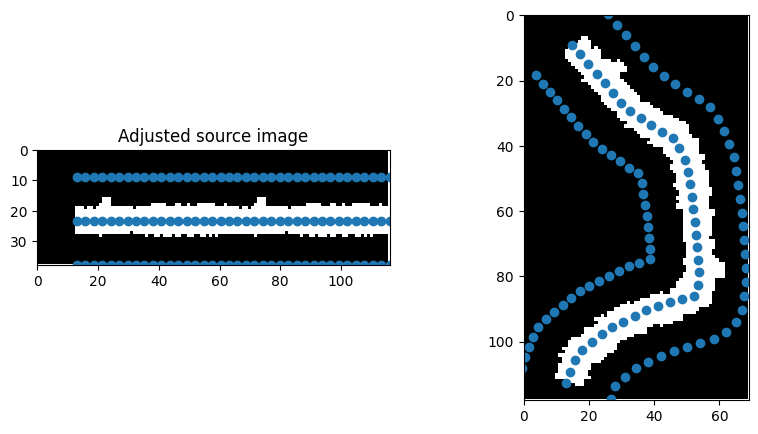

In [91]:
rows_bin, cols_bin = mapa_expandido_bin.shape[0], mapa_expandido_bin.shape[1]

src_cols_bin = np.linspace(0, cols_bin, maior_tamanho)
src_rows_bin = np.linspace(0, rows_bin, 3)
src_cols_bin, src_rows_bin = np.meshgrid(src_cols_bin,src_rows_bin)
src_bin = np.dstack([src_cols_bin.flat, src_rows_bin.flat])[0]


img_proper_bin, img_out_bin, new_src_bin, new_dst_bin, tform_out_bin = backgen.transform_v2(src_bin, dst_array_np, mapa_expandido_bin)
backgen.plot(img_proper_bin, img_out_bin, new_src_bin, new_dst_bin, vmax=1)

### Exibição da máscara expandida rotacionada

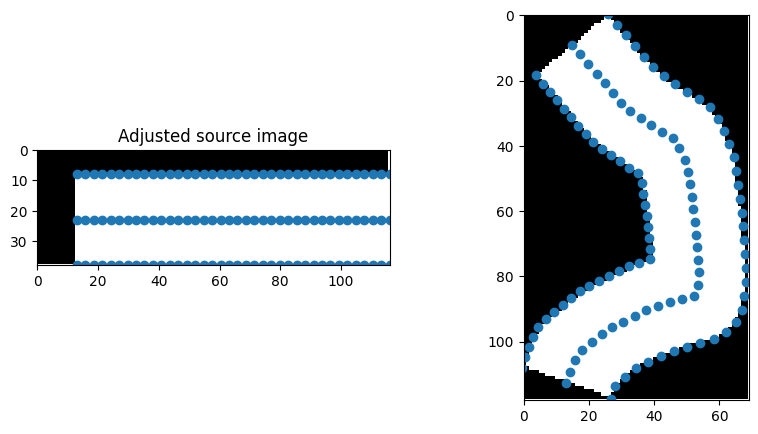

In [92]:
rows_transf_bin, cols_transf_bin = mask_mapa_expandido_bin.shape[0], mask_mapa_expandido_bin.shape[1]

src_cols_transf_bin = np.linspace(0, cols_transf_bin, maior_tamanho)
src_rows_transf_bin = np.linspace(-1, rows_transf_bin, 3)
src_cols_transf_bin, src_rows_transf_bin = np.meshgrid(src_cols_transf_bin,src_rows_transf_bin)
src_transf_bin = np.dstack([src_cols_transf_bin.flat, src_rows_transf_bin.flat])[0]


img_proper_transf_bin, img_out_transf_bin, new_src_transf_bin, new_dst_transf_bin, tform_transf_bin= backgen.transform_v2(src_transf_bin, dst_array_np, mask_mapa_expandido_bin)
backgen.plot(img_proper_transf_bin, img_out_transf_bin, new_src_transf_bin, new_dst_transf_bin, vmax=1)

Plotando os pontos alterados

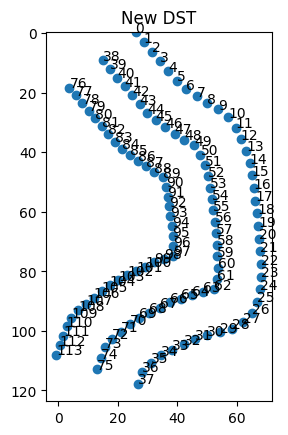

In [111]:
pontos_x = new_dst[:,0]
pontos_y = new_dst[:,1]
backgen.plotar_pontos(pontos_x, pontos_y, 'New DST')

### Exibindo o mapa original e os modificados

[]

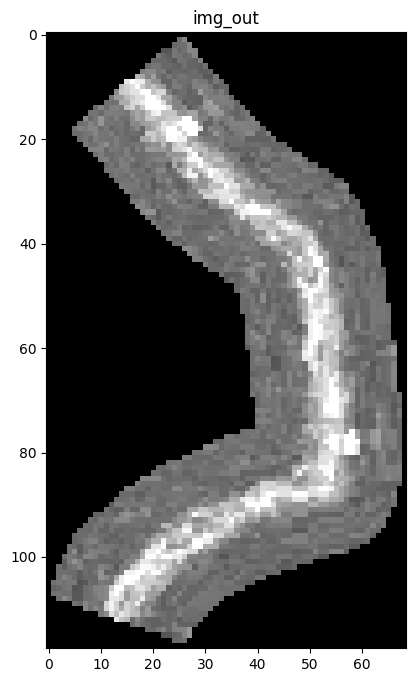

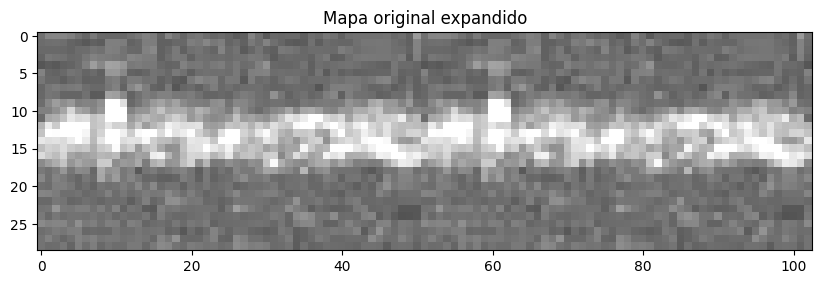

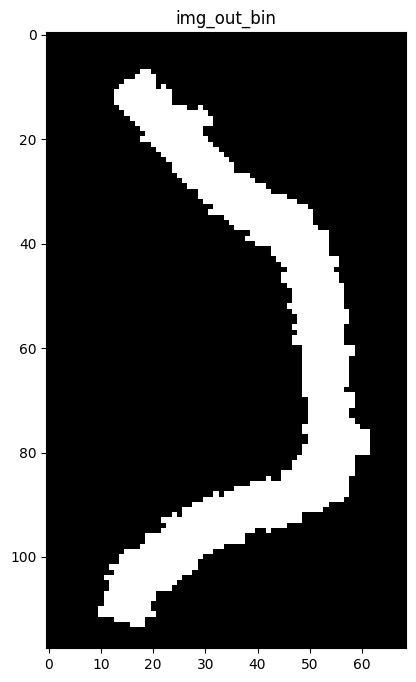

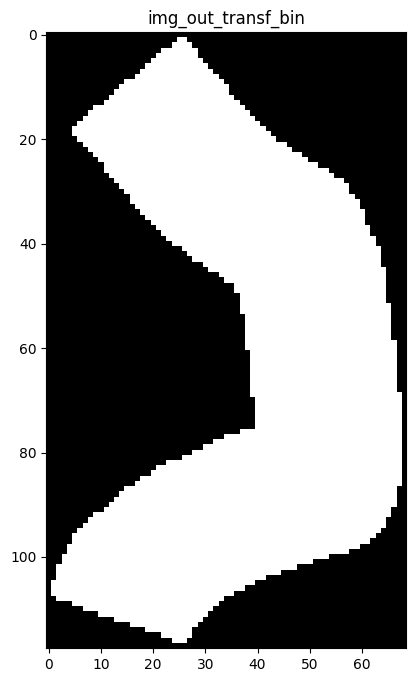

In [93]:
plt.figure(figsize=[10, 8])
plt.title("img_out")
plt.imshow(img_out, 'gray', vmin=0, vmax=60)
plt.plot()

plt.figure(figsize=[10, 8])
plt.title("Mapa original expandido")
plt.imshow(mapa_expandido_original, 'gray', vmin=0, vmax=60)
plt.plot()

plt.figure(figsize=[10, 8])
plt.title("img_out_bin")
plt.imshow(img_out_bin, 'gray', vmin=0, vmax=1)
plt.plot()

plt.figure(figsize=[10, 8])
plt.title("img_out_transf_bin")
plt.imshow(img_out_transf_bin, 'gray', vmin=0, vmax=1)
plt.plot()

In [94]:
import cv2
from scipy import ndimage

kernel = np.ones((3,3),np.uint8)

opening = cv2.morphologyEx(img_out_bin_sq, cv2.MORPH_OPEN, kernel)

teste =ndimage.binary_erosion(img_out_bin_sq, structure=np.ones((3,3))).astype(img_out_bin_sq.dtype)

[]

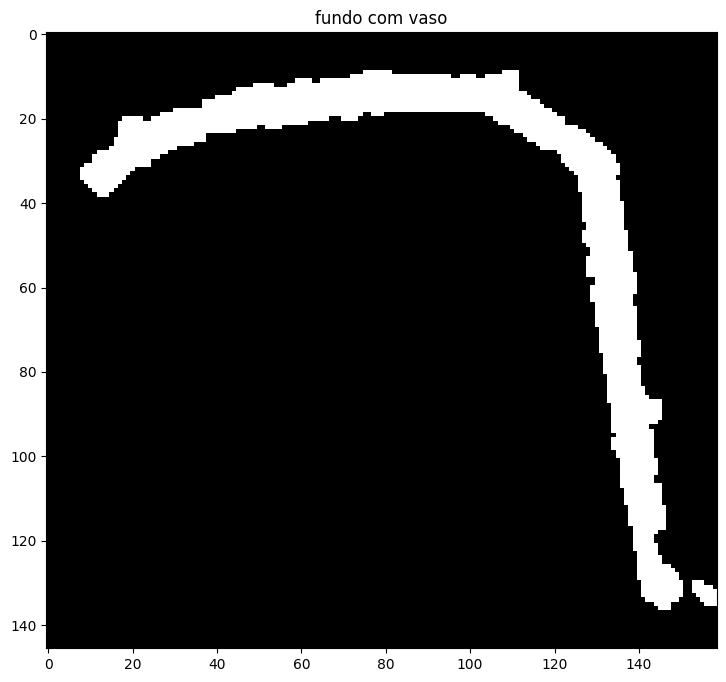

In [95]:
plt.figure(figsize=[10, 8])
plt.title("fundo com vaso")
plt.imshow(opening, 'gray', vmin=0, vmax=1)
plt.plot()

### Inserindo o mapa em um background criado artificialmente

[]

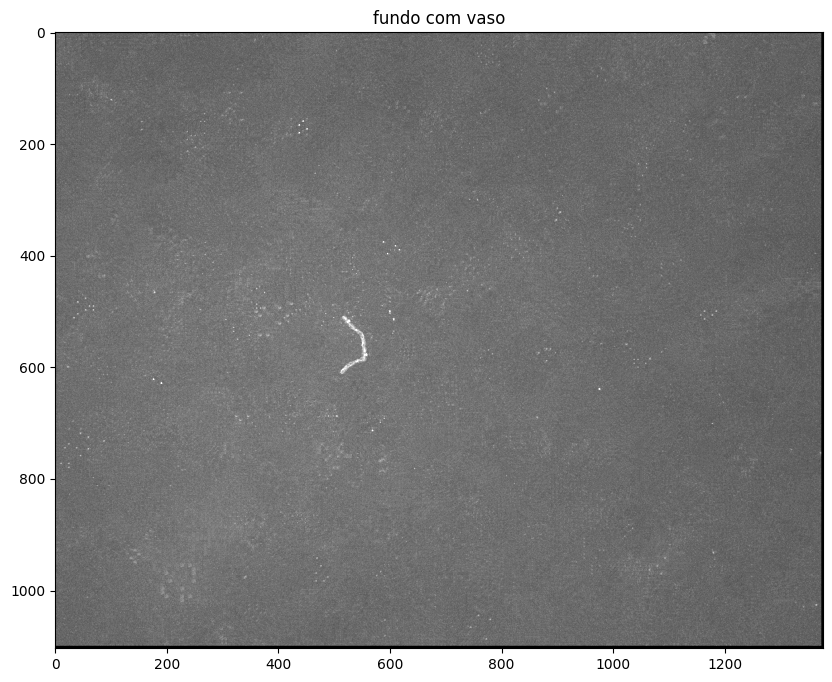

In [96]:

back_artif = np.array(Image.open(root_dir + f'/Background/Mapas_gerados_artificialmente/{imag}.tiff'))

img_out_sq = img_out.squeeze()
img_out_transf_sq = img_out_transf_bin.squeeze()

#Mergear
#fundo = backgen.estimate_background(img, label)

# img_out_sq = mapa transformado
# img_out_bin_sq = vaso binário transformado
# img_out_transf_bin_sq = mapa binário transformado

img_out_bin_sq = img_out_bin.squeeze()

point = (500,500)
limiar = 30
background = back_artif
img_merged = backgen.inserindo_vaso_fundo2(img_out_sq,img_out_bin_sq,background,point,limiar)

plt.figure(figsize=[10, 8])
plt.title("fundo com vaso")
plt.imshow(img_merged, 'gray', vmin=0, vmax=60)
plt.plot()

### Exibindo os triângulos de Delaunay

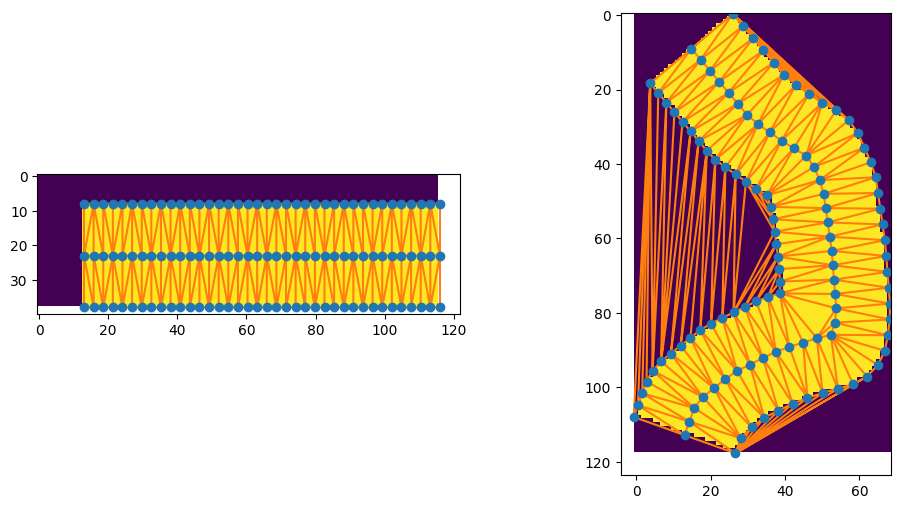

In [97]:
from skimage.transform import PiecewiseAffineTransform, warp
#img_proper_transf_bin, img_out_transf_bin, new_src_transf_bin, new_dst_transf_bin, tform_transf_bin

tri = tform_transf_bin._tesselation 
tri_inv = tform_transf_bin._inverse_tesselation 
backgen.delaunay_plot(img_proper_transf_bin, img_out_transf_bin, tri, tri_inv)